In [2]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt

from statistics import mean
from PIL import Image
from collections import Counter, defaultdict

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard


## Nombre d'avis en commun pour créé label :

In [4]:
min_avis = 4

## Créé fonction csv

In [ ]:
# Le dossier où il y a les images, pour récupérer chaque txt
def info_data(txt_folder):
    data = []
    for txt_file in os.listdir(txt_folder):
        if txt_file.endswith('.txt'):
            with open(os.path.join(txt_folder, txt_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    avis = parts[0]
                    xc = parts[-4]
                    yc = parts[-3]
                    w = parts[-2]
                    h = parts[-1]
                    other = parts[1:-4]
                    file_id = txt_file.replace('.txt', '')
                    data.append([file_id, avis] + [xc, yc, w, h] + other)
    columns = ['id', 'avis'] + ['xc', 'yc', 'w', 'h'] + ['classe','year'] + [f'info{i+2}' for i in range(4)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('info_data.csv', index=False)

## CLasse python image et background

In [5]:
class BackgroundDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, num_samples=1000):
        """
        Dataset qui génère des images de fond (classe 8) en évitant les bounding boxes existantes.

        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            num_samples (int): Nombre de samples de background à générer.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.num_samples = num_samples

        # Charger les informations du dataset original
        self.data = pd.read_csv(csv_file)
        self.boxes = self._load_boxes()
        self.image_ids = list(self.boxes.keys())  # Liste des images disponibles

    def _load_boxes(self):
        """
        Charge toutes les bounding boxes sous forme de dictionnaire {image_id: [bbox_list]}.
        """
        boxes = {}
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            if image_id not in boxes:
                boxes[image_id] = []
            boxes[image_id].append(bbox)
        return boxes

    def _get_random_background_patch(self, image, bboxes):
        """
        Extrait une zone aléatoire de l'image en évitant les bounding boxes existantes.
        """
        width, height = image.size
        patch_size = 822  # Taille fixe du patch

        for _ in range(10):  # Essayer 10 fois de trouver une zone correcte
            x = random.randint(0, width - patch_size)
            y = random.randint(0, height - patch_size)

            # Vérifier si la zone chevauche une bounding box
            overlaps = False
            for (xc, yc, w, h) in bboxes:
                x_min = int((xc - w / 2) * width)
                x_max = int((xc + w / 2) * width)
                y_min = int((yc - h / 2) * height)
                y_max = int((yc + h / 2) * height)

                if not (x_max < x or x_min > x + patch_size or y_max < y or y_min > y + patch_size):
                    overlaps = True
                    break
            
            if not overlaps:
                return image.crop((x, y, x + patch_size, y + patch_size))

        # Si aucune zone correcte n'a été trouvée après 10 essais, prendre une zone au hasard
        return image.crop((0, 0, patch_size, patch_size))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Retourne un patch de fond et le label 8.
        """
        image_id = random.choice(self.image_ids)
        image_path = os.path.join(self.images_dir, f"{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")

        bboxes = self.boxes[image_id]
        background_patch = self._get_random_background_patch(image, bboxes)

        if self.transform:
            background_patch = self.transform(background_patch)
            
        label = torch.tensor(8, dtype=torch.long)

        return background_patch, label
    
    
class ImageBoundingBoxDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train", "val" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        
        self.data = pd.read_csv(csv_file)
        self.boxes = self._create_boxes_list()

        self._split_data()

        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            if label not in [None, 0, 8]:  
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'label': label
                })
        return boxes

    def _split_data(self):
        """
        Effectue le split de l'ensemble de données en train, validation et test,
        et choisit le split actif.
        """
        labels = [box["label"] for box in self.boxes]
        train_data, test_data = train_test_split(self.boxes, test_size=0.4, random_state=self.seed, stratify=labels)

        # Choisir le dataset basé sur le split demandé
        if self.split == "train":
            self.data_split = train_data
        elif self.split == "test":
            self.data_split = test_data
        else:
            raise ValueError("Split must be one of ['train', 'val', 'test']")

    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.data_split:
            label = annotation['label']
            class_counts[label] += 1
        return dict(class_counts)


    def avis_majoritaire(self, avis, min_count=min_avis):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)
        
        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])
        
        if occurrences >= min_count:
            return int(majoritaire)
        
        return None


    def __len__(self):
        return len(self.data_split)


    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.data_split[idx]
        bbox = annotation['bbox']
        label = annotation['label']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)
            
        label = torch.tensor(label, dtype=torch.long)
            
        return cropped_image, label


class Autre_Dataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train", "val" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        
        self.data = pd.read_csv(csv_file)
        self.boxes = self._create_boxes_list()

        self._split_data()

        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            if label in [0]:  
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'label': label
                })
        return boxes

    def _split_data(self):
        """
        Effectue le split de l'ensemble de données en train, validation et test,
        et choisit le split actif.
        """
        labels = [box["label"] for box in self.boxes]
        train_data, test_data = train_test_split(self.boxes, test_size=0.4, random_state=self.seed, stratify=labels)

        # Choisir le dataset basé sur le split demandé
        if self.split == "train":
            self.data_split = train_data
        elif self.split == "test":
            self.data_split = test_data
        else:
            raise ValueError("Split must be one of ['train', 'val', 'test']")

    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.data_split:
            label = annotation['label']
            class_counts[label] += 1
        return dict(class_counts)


    def avis_majoritaire(self, avis, min_count=min_avis):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)
        
        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])
        
        if occurrences >= min_count:
            return int(majoritaire)
        
        return None


    def __len__(self):
        return len(self.data_split)


    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.data_split[idx]
        bbox = annotation['bbox']
        label = annotation['label']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)
            
        label = torch.tensor(label, dtype=torch.long)
            
        return cropped_image, label

## Création du dataset

In [7]:
img_dir = "./data"
csv_file = "./info_data.csv"

image_size = 800
BATCH_SIZE = 4
LR = 1e-4
num_classes = 9
EPOCH = 10

transform = transforms.Compose([
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
    ])

transform_autre = transforms.Compose([
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
    ])


train_dataset = ImageBoundingBoxDataset(images_dir=img_dir, csv_file=csv_file, transform=transform, split='train')
test_dataset = ImageBoundingBoxDataset(images_dir=img_dir, csv_file=csv_file, transform=transform, split='test')

# Mettre en commentaire les lignes du background si pas besoin
train_background = BackgroundDataset(img_dir, csv_file, transform=transform, num_samples=int(mean(train_dataset.class_counts.values())))
test_background = BackgroundDataset(img_dir, csv_file, transform=transform, num_samples=int(mean(test_dataset.class_counts.values())))

# Data pour la classe 0
train_dataset_autre = Autre_Dataset(images_dir=img_dir, csv_file=csv_file, transform=transform, split='train')
test_dataset_autre = Autre_Dataset(images_dir=img_dir, csv_file=csv_file, transform=transform, split='test')

train_data_background = torch.utils.data.ConcatDataset([train_dataset, train_background, train_dataset_autre])
test_data_background = torch.utils.data.ConcatDataset([test_dataset, test_background, test_dataset_autre])

full_data_background = torch.utils.data.ConcatDataset([train_data_background, test_data_background])
full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

## Dataloader pour model pytorch

In [ ]:
train_loader = DataLoader(train_data_background, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data_background, batch_size=BATCH_SIZE, shuffle=False)
full_loader = DataLoader(full_data_background, batch_size=BATCH_SIZE, shuffle=True)

## Dataloader pour model tf / keras

In [ ]:
def torch_to_tf_dataset(dataloader):
    def gen():
        for images, labels in dataloader:
            yield images.numpy(), labels.numpy()

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 3, image_size, image_size), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
        )
    )
    
train_ds = torch_to_tf_dataset(train_loader)
test_ds = torch_to_tf_dataset(test_loader)
full_ds = torch_to_tf_dataset(full_loader)

## Test des données

In [ ]:
# Distribution des classes
proportions = {key: train_dataset.class_counts[key] / test_dataset.class_counts[key] for key in train_dataset.class_counts if key in test_dataset.class_counts and test_dataset.class_counts[key] != 0}
proportions

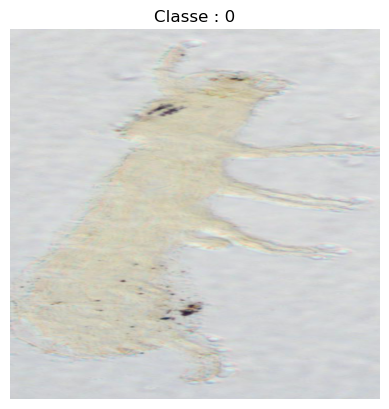

In [9]:
# Afficher une image
image, label = train_dataset_autre[151]
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Classe : {label}")
plt.axis('off')
plt.show()

## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

In [ ]:
# Define a custom macro F1 metric
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='f1_macro', **kwargs):
        super(F1Macro, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        # Initialize accumulators for true positives, false positives, and false negatives
        self.tp = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
      # Convert probabilities to predicted class indices
      y_pred = tf.argmax(y_pred, axis=1)
      y_true = tf.cast(y_true, tf.int64)

      # One-hot encode the labels
      y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
      y_pred_one_hot = tf.one_hot(y_pred, depth=self.num_classes)

      # Compute per-class true positives, false positives, and false negatives
      tp = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
      fp = tf.reduce_sum((1 - y_true_one_hot) * y_pred_one_hot, axis=0)
      fn = tf.reduce_sum(y_true_one_hot * (1 - y_pred_one_hot), axis=0)

      # Update the metric variables in a vectorized manner
      self.tp.assign_add(tp)
      self.fp.assign_add(fp)
      self.fn.assign_add(fn)

    def result(self):
        # Compute precision and recall per class
        precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
        recall = tf.math.divide_no_nan(self.tp, self.tp + self.fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        # Return the macro-average F1 score
        return tf.reduce_mean(f1)

    def reset_states(self):
        for var in self.variables:
            var.assign(tf.zeros_like(var))

In [ ]:
run_name = f"CNN_ivan_{BATCH_SIZE}BATCH_{LR}LR_{EPOCH}EPOCH_{image_size}SIZE"
log_dir = os.path.join("tensorboard", run_name)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)


x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(num_classes)]
)

history = model.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=test_ds,
    callbacks=[tensorboard_callback]
)